## Важно:

Пожалуйста, поддерживайте ваш код в хорошем состоянии, пишите комментарии, убирайте бесполезные ячейки, пишите модели в специально отведенных модулях. Проверяющие могут **НА СВОЕ УСМОТРЕНИЕ** снижать баллы за:

1. Говнокод
2. Неэффективные решения
3. Вермишель из ячеек в тетрадке
4. Все остальное что им не понравилось

## Важно 2 (0 - 0.3 балла):

За использование логгеров типа wandb/comet/neptune и красивую сборку этой домашки в виде графиков/картинок в этих логгерах мы будем выдавать бонусные баллы. 

## Важно 3:

Решением домашки является архив с использованными тетрадками/модулями, а так же **.pdf файл** с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать модели которые вы использовали (например denoising AE или sparce AE в пункте 1)




In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from tqdm.notebook import tqdm


import matplotlib.pyplot as plt
%matplotlib inline

В этом домашнем задании мы будем автоэнкодить Omniglot. Omniglot - это датасет в основном для few-shot learning'а, состоящий из рукописных символов из разных существующих и несуществующих (эльфийский, клингонский) языков.

В этом датасете очень много классов, для для каждого класса представлено только 10-20 картинок. Если учить честную классификацию, мы быстро столкнемся с тем, что модель не сможет нормально выучиться.

В этой тетрадке вам предлагается попробовать решить эту проблему - выучить автоэнкодер (любой формы) и, используя латентное его представление, делать классификацию более сложными методами на меньше размерности.

Omniglot очень странно построен, в нем background - это единицы, а не нули. Чтобы перевести это в удобный для нас формат - инвертируем каждый пиксель через нашу кастомную трансформацию - InvertImage


In [3]:
class InvertImage:
    def __call__(self, pic):
        return 1 - pic

    def __repr__(self):
        return self.__class__.__name__ + '()'


In [4]:
from omniglot import FullOmniglot
from torchvision import transforms

from torch.utils.data import DataLoader, Subset

from sklearn.model_selection import train_test_split

data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    InvertImage(),
    transforms.Normalize([0.5], [0.5])
])

cuda_num = 0
device = f'cuda:{cuda_num}' if torch.cuda.is_available() else 'cpu'
batch_size = 64


Мы используем кастомный датасет FullOmniglot потому что изначально train/val части омниглота использую разные классы. Мы обьединяем их и делаем свое разбиение

In [5]:
full_dataset = FullOmniglot('./Omniglot', transform=data_transforms, download=True)

labels = [label for _, label in full_dataset]
    
# делаем так, чтобы сплит был сбалансированным по классам
indices_train, indices_test, _, _ = train_test_split(list(range(len(labels))), labels, test_size=0.1, stratify=labels)

train_dataset = Subset(full_dataset, indices=indices_train)
test_dataset = Subset(full_dataset, indices=indices_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
def process_image(image):
    return (image.squeeze().detach().to('cpu') + 1) / 2

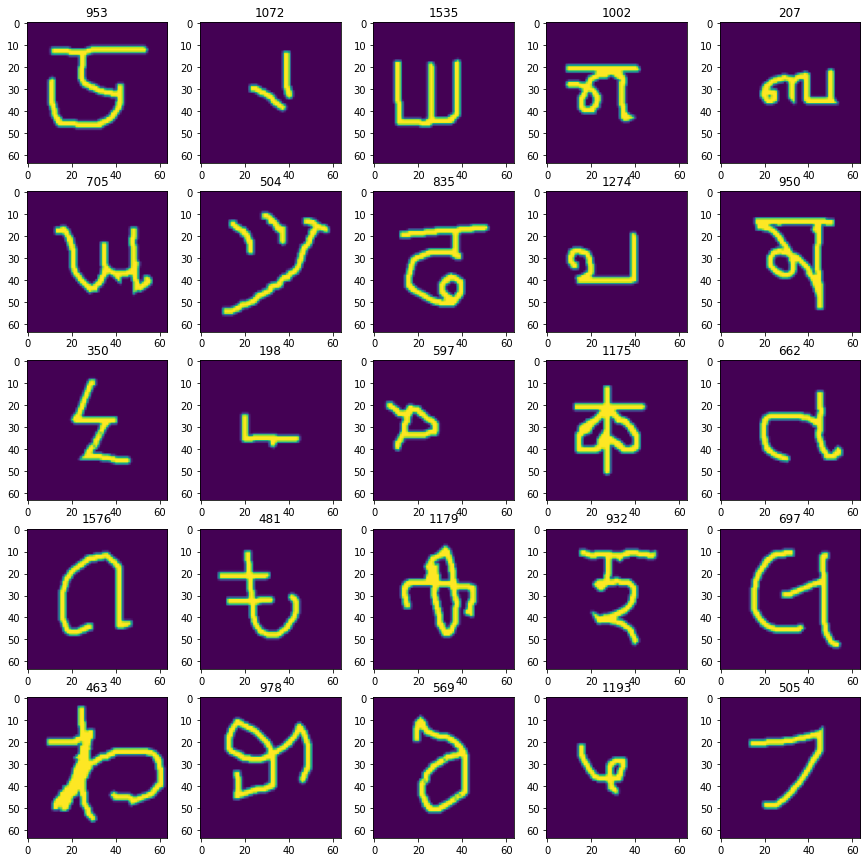

In [6]:
test_batch = next(iter(train_loader))

plt.figure(figsize=(15, 15))
for ind, (image, label) in enumerate(zip(*test_batch)):
    if ind >= 25: break
    plt.subplot(5, 5, ind+1)
    plt.imshow(process_image(image))
    plt.title(label.item())
plt.show()    

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Для того чтобы писать красивый код и не делать тетрадку слишком длинной предлагается писать свои модели в отдельном модуле, см `./autoencoder.py`

### Задача 1 (0.3 балла):

Написать свой автоэнкодер, доучить его до приличного качества

#### Denoising autoencoder

!!! Можно не тренировать с листа, а прокрутить ниже и загрузить обученную модель.

Классический трейнлуп:

Note: я буду уважать вас сильнее если вместо вывода графика в тетрадку вы будете логгировать все (лоссы + картинки) в wandb/comet/neptune. И так далее по ходу тетрадки тоже

In [8]:
!pip install wandb -qqq
import wandb

!wandb login

wandb: Currently logged in as: exxxplainer (use `wandb login --relogin` to force relogin)


Создам функцию для тренировки автоэнкодера.

In [9]:
def train_autoencoder(model, train_config, epochs, data_loader, wandb_config, start_logging = True):
    optim, criterion, device = train_config
    project_name, config = wandb_config

    if start_logging:
        wandb.init(project=project_name, config=config)
        wandb.watch(model)

    losses = []
    model.train()
    log_freq = 100

    for epoch in tqdm(range(epochs)):
        for batch_index, (image, _) in enumerate(data_loader):
            optim.zero_grad()
            image = image.to(device)
            out = model(image)
            loss = criterion(out, image)
            loss.backward()
            optim.step()
            losses.append(loss.item())

            if batch_index % log_freq == log_freq - 1:
                running_loss = sum(losses[-log_freq:]) / log_freq
                wandb.log({'running_loss': running_loss})

    return losses

In [11]:
from autoencoder import AutoEncoder

dae = AutoEncoder().to(device)
optim = torch.optim.Adam(dae.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [13]:
config = {
    "architechture": "Denoising",
    "loss": "MSE",
    "dataset": "Omniglot"
}

In [14]:
losses = train_autoencoder(
    model = dae, 
    train_config = (optim, criterion, device), 
    epochs = 20,
    data_loader = train_loader,
    wandb_config = ('DeepGenModels-AE-homework', config),
    start_logging = True
)

wandb: Currently logged in as: exxxplainer (use `wandb login --relogin` to force relogin)


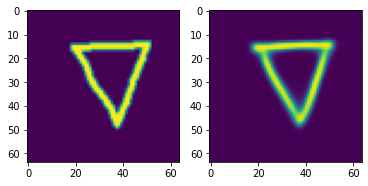

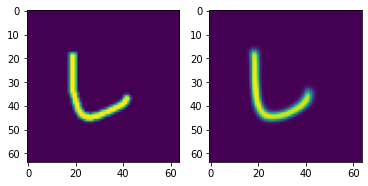

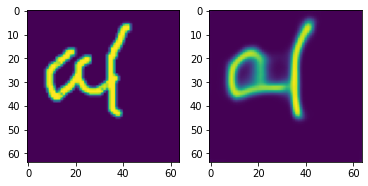

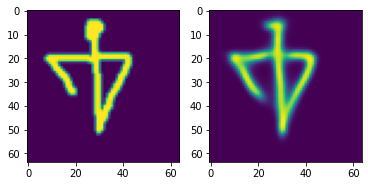

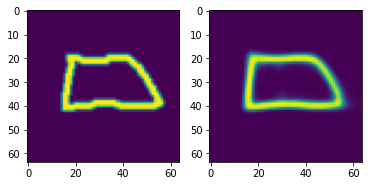

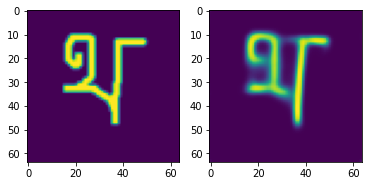

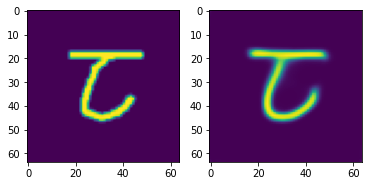

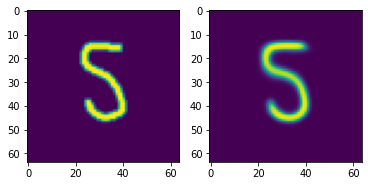

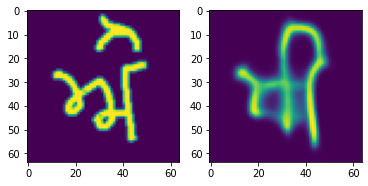

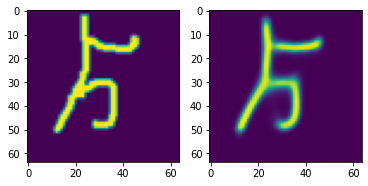

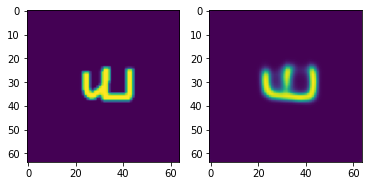

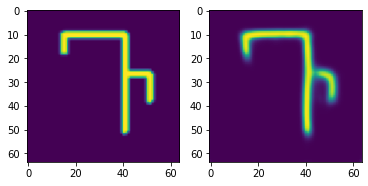

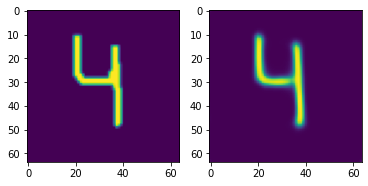

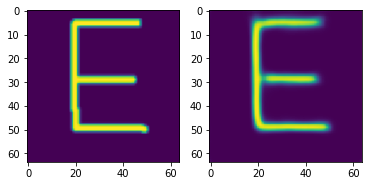

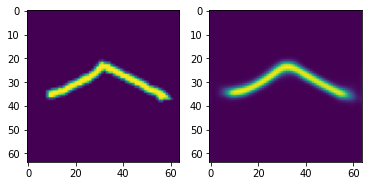

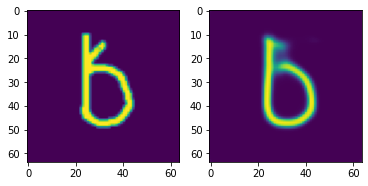

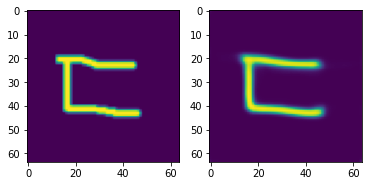

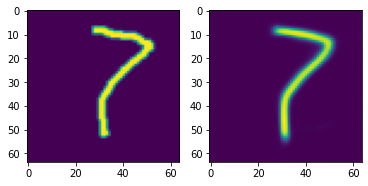

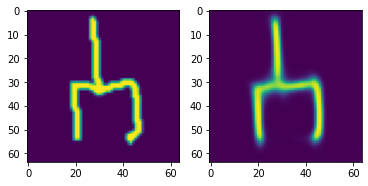

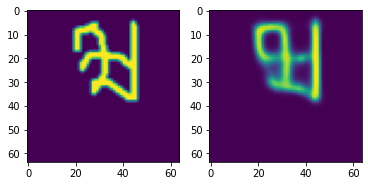

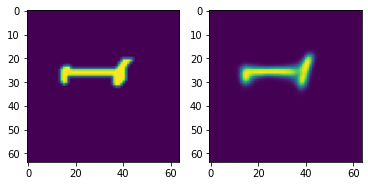

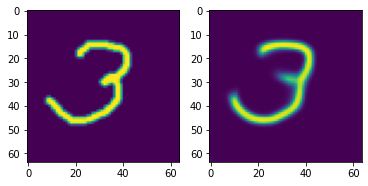

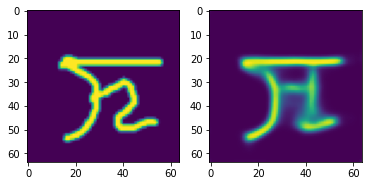

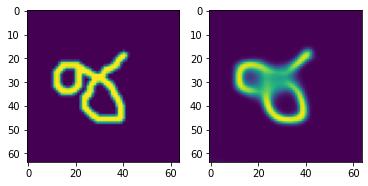

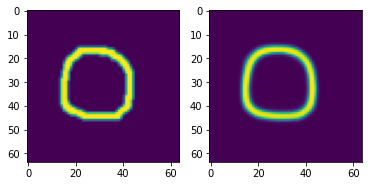

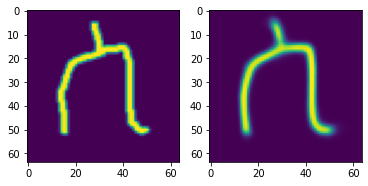

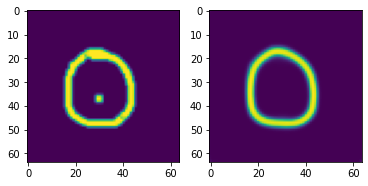

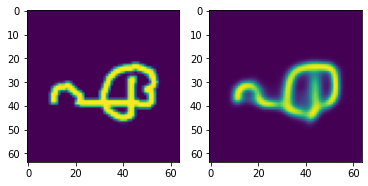

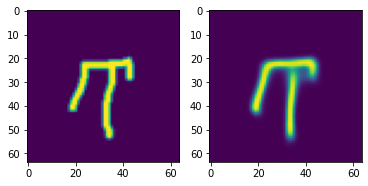

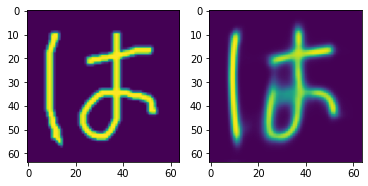

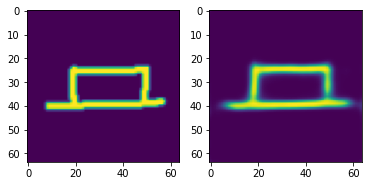

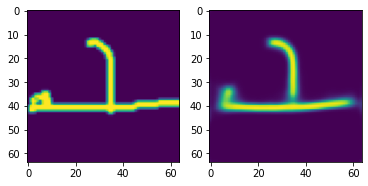

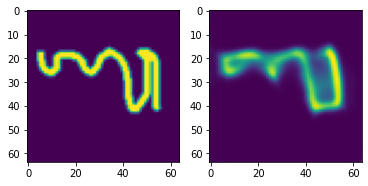

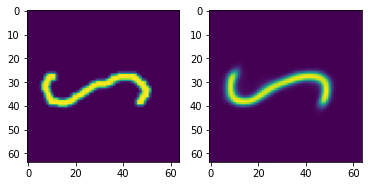

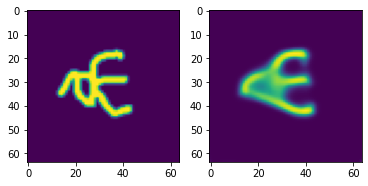

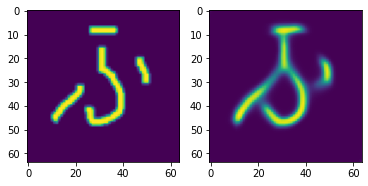

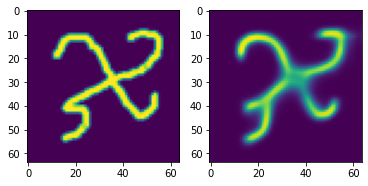

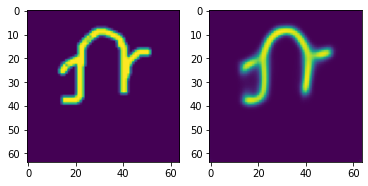

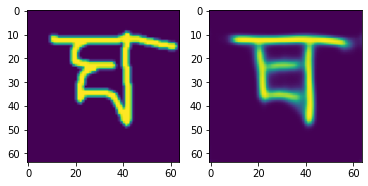

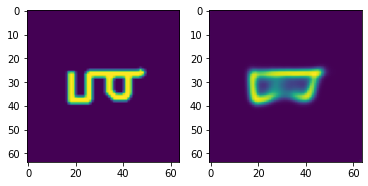

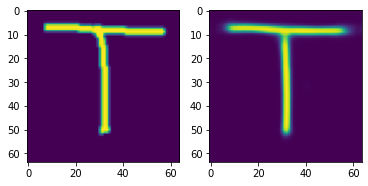

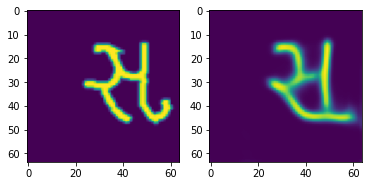

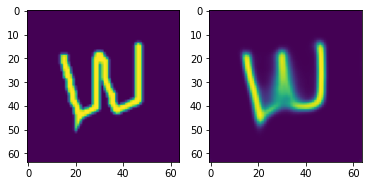

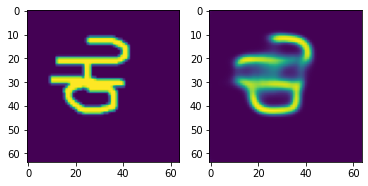

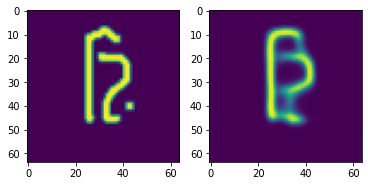

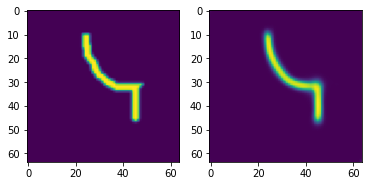

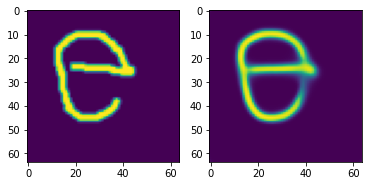

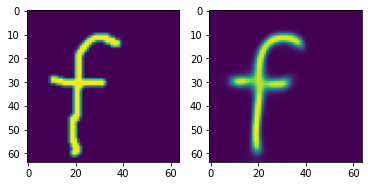

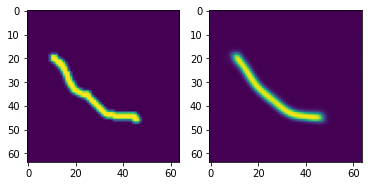

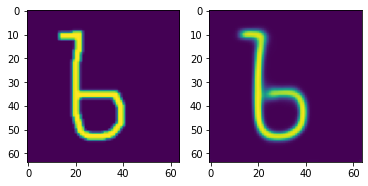

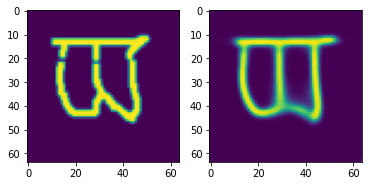

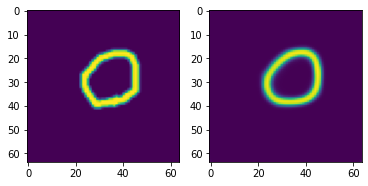

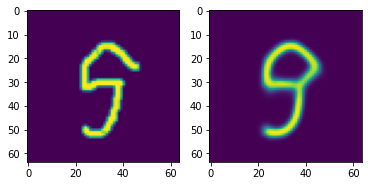

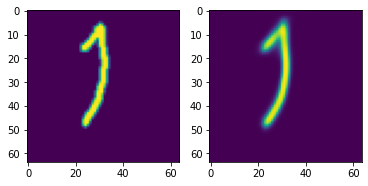

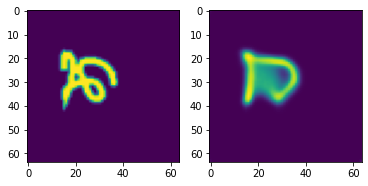

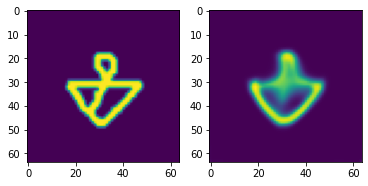

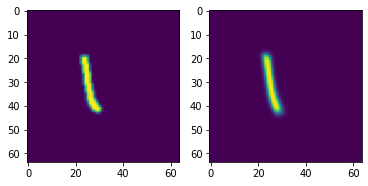

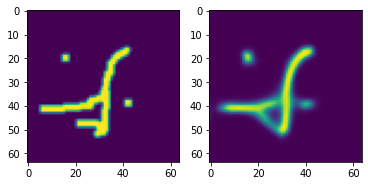

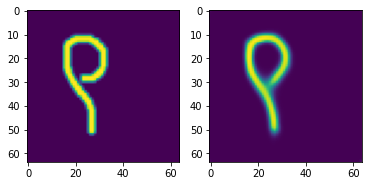

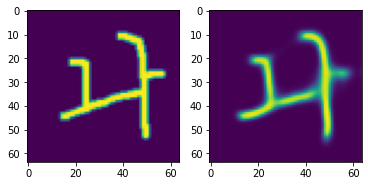

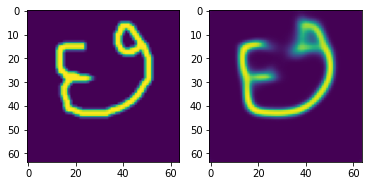

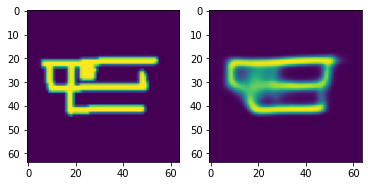

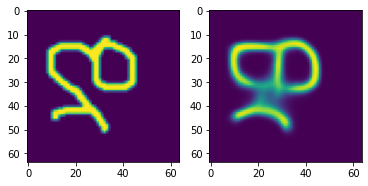

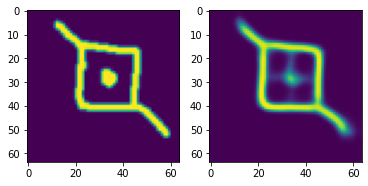

In [15]:
test_batch = next(iter(test_loader))
dae.eval()

for image in test_batch[0]:
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze())
    plt.subplot(1, 2, 2)
    plt.imshow(dae(image.unsqueeze(0).to(device)).squeeze().detach().to('cpu'))
    plt.show()

In [16]:
criterion = nn.MSELoss()
dae.eval()
test_losses = []

for image, _ in tqdm(test_loader, desc='test', leave = False):
    image = image.to(device)
    out = dae(image)
    loss = criterion(out, image)
    test_losses.append(loss.item())

print('Mean test loss is ', sum(test_losses) / len(test_losses))
wandb.log({'Mean test loss': sum(test_losses) / len(test_losses)})

Mean test loss is  0.04196732632815838


После 20 эпох модель выдавала что-то адекватное, поэтому я решил поучить ещё.

In [ ]:
losses = train_autoencoder(
    model = dae,
    train_config = (optim, criterion, device),
    epochs = 80,
    data_loader = train_loader,
    wandb_config = ('DeepGenModels-AE-homework', config),
    start_logging = False
)

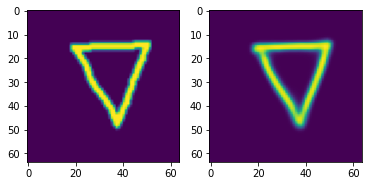

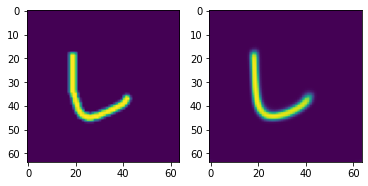

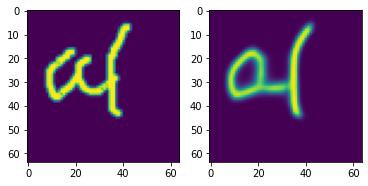

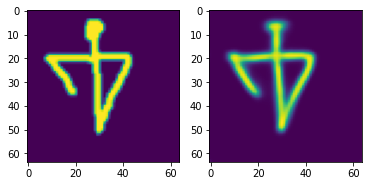

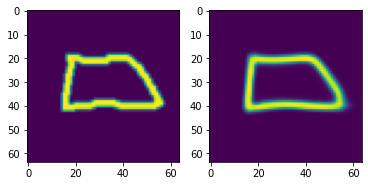

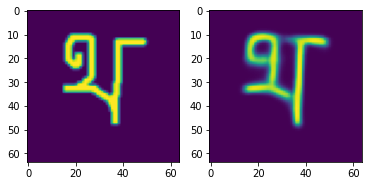

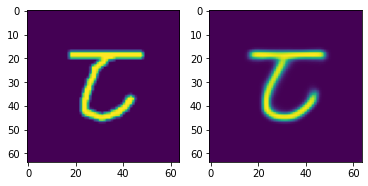

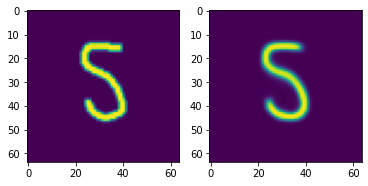

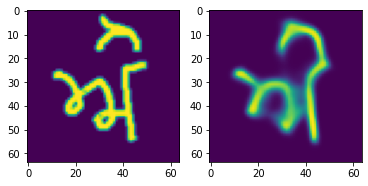

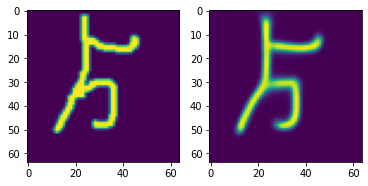

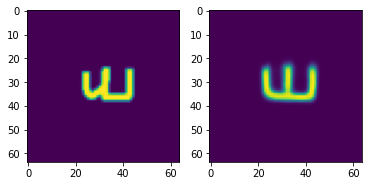

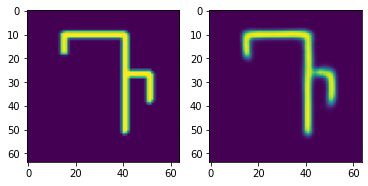

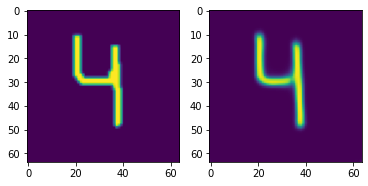

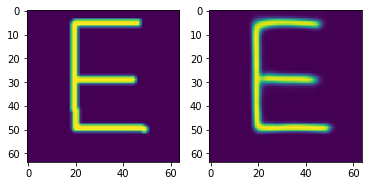

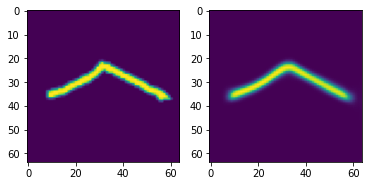

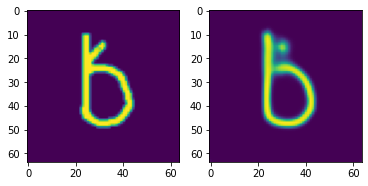

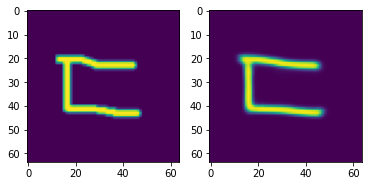

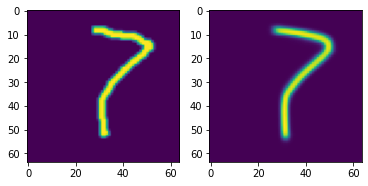

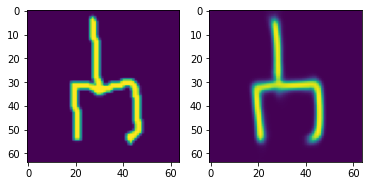

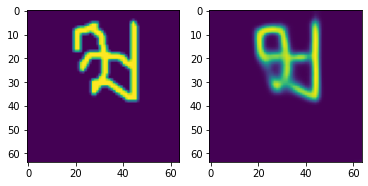

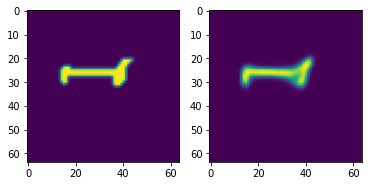

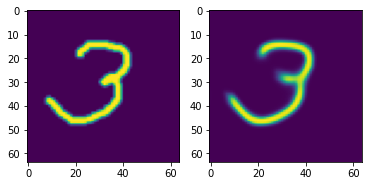

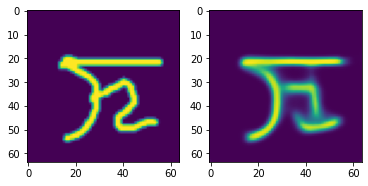

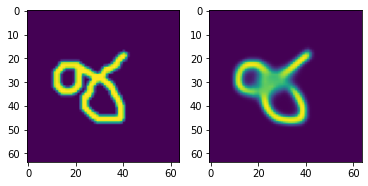

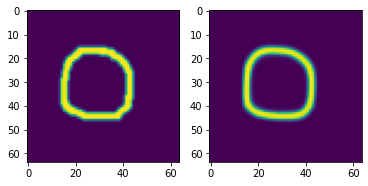

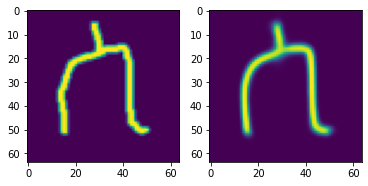

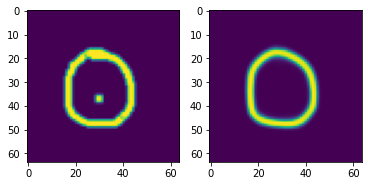

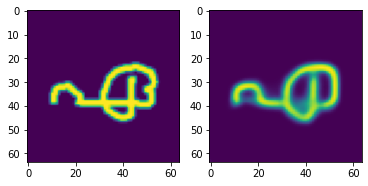

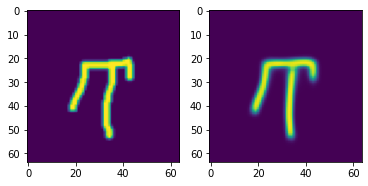

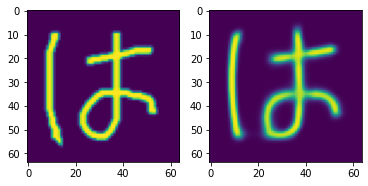

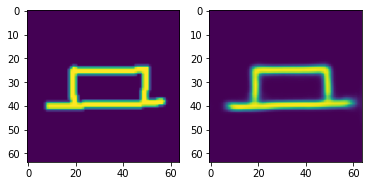

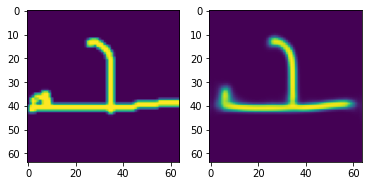

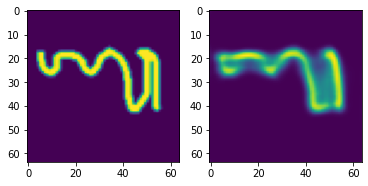

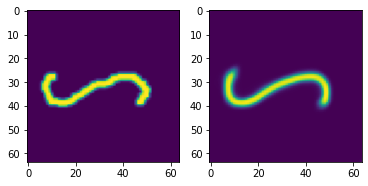

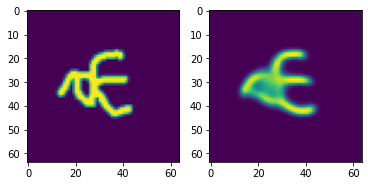

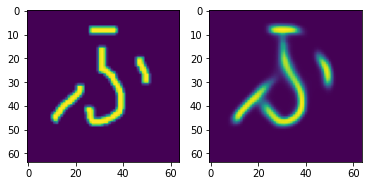

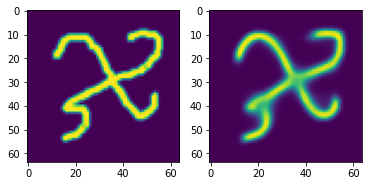

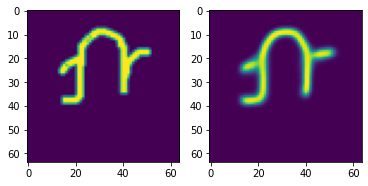

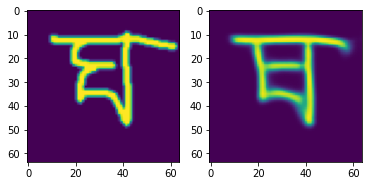

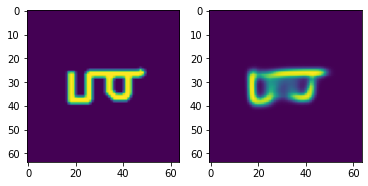

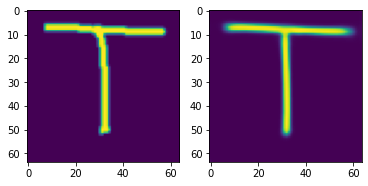

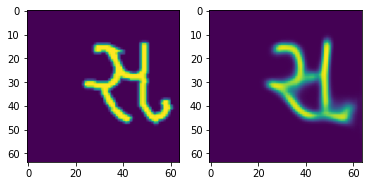

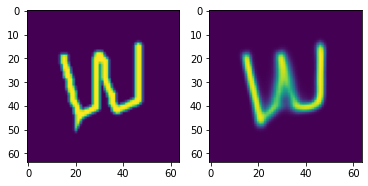

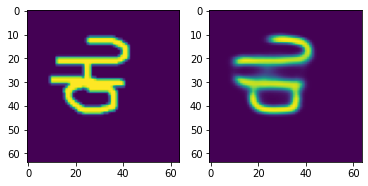

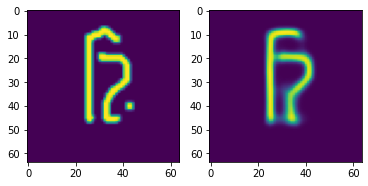

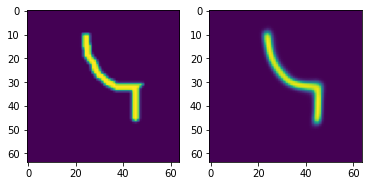

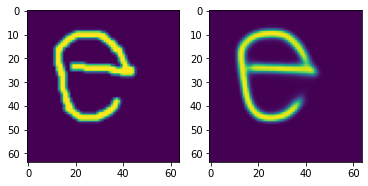

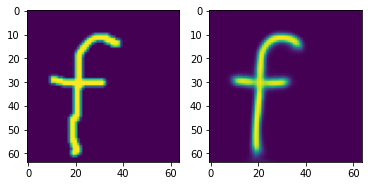

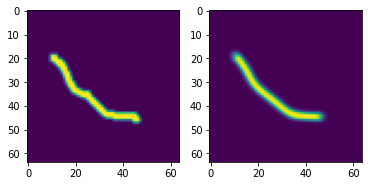

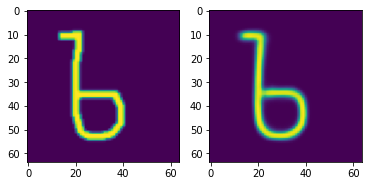

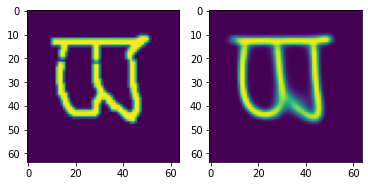

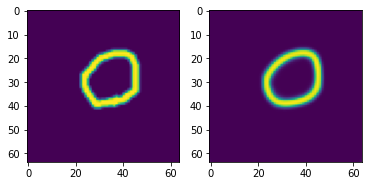

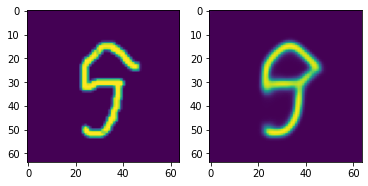

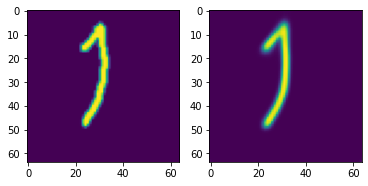

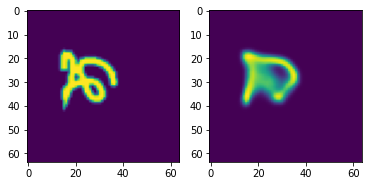

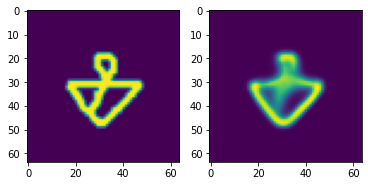

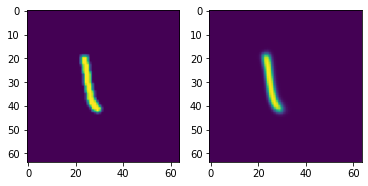

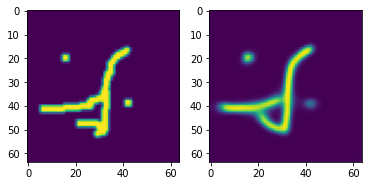

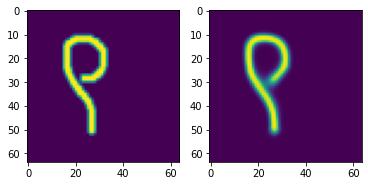

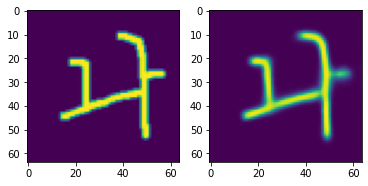

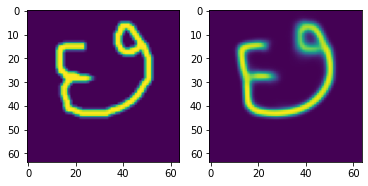

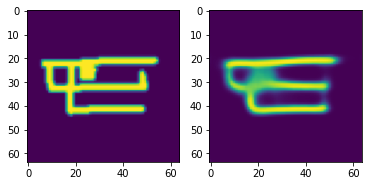

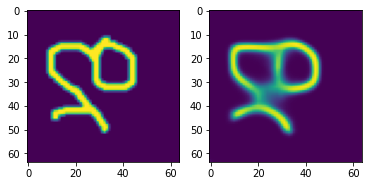

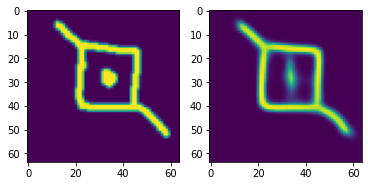

In [19]:
test_batch = next(iter(test_loader))
dae.eval()

for image in test_batch[0]:
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze())
    plt.subplot(1, 2, 2)
    plt.imshow(dae(image.unsqueeze(0).to(device)).squeeze().detach().to('cpu'))
    plt.show()

#### Загрузка обученной модели

In [18]:
from autoencoder import AutoEncoder

dae = AutoEncoder().to(device)
path = 'drive/MyDrive/Colab Notebooks/'
dae.load_state_dict(torch.load(path + 'dae_0.03.pth'))

<All keys matched successfully>

#### Проверка denoising autoencoder-а на тесте

In [20]:
dae.eval()
criterion = nn.MSELoss()
test_losses = []

for image, _ in tqdm(test_loader, desc='test', leave = False):
    image = image.to(device)
    out = dae(image)
    loss = criterion(out, image)
    test_losses.append(loss.item())

print('Mean test loss is ', sum(test_losses) / len(test_losses))
#wandb.log({'Test losses': test_losses, 'Mean test loss': sum(test_losses) / len(test_losses)})

Mean test loss is  0.031192405000329018


In [ ]:
# torch.save(dae.state_dict(), '/content/drive/MyDrive/Colab Notebooks/dae_0.03.pth')

#### Sparse autoencoder

!!! Можно не учить с листа, а прокрутить ниже и загрузить обученную модель.

In [26]:
from sparse_autoencoder import SparseAutoEncoder

sae = SparseAutoEncoder().to(device)
optim = torch.optim.Adam(sae.parameters(), lr = 0.001)
criterion = nn.MSELoss()

In [24]:
def l1_loss(model):
    regularization_loss = 0
    
    for param in model.parameters():
        regularization_loss += torch.sum(torch.abs(param))
    
    return regularization_loss

Напишем функцию для l1-регуляризации

In [27]:
config = {
    "architechture": "Sparse",
    "regularization": "l1",
    "loss": "MSE",
    "learning_rate": 0.001,
    "dataset": "Omniglot"
}

И для непосредственно тренировки

In [28]:
def train_sparse_autoencoder(model, train_config, epochs, data_loader, wandb_config, start_logging):
    optim, criterion, device = train_config
    project_name, config = wandb_config

    if start_logging:
        wandb.init(project=project_name, config=config)
        wandb.watch(model)

    losses = []
    losses_with_l1 = []
    model.train()
    log_freq = 100

    for epoch in tqdm(range(epochs), desc = 'epoch'):
        for batch_index, (image, _) in enumerate(data_loader):
            optim.zero_grad()
            image = image.to(device)
            out = model(image)
            loss = criterion(out, image)
            reg_loss = l1_loss(model)
            losses.append(loss.item())

            loss += 0.0001 * reg_loss
            loss.backward()
            optim.step()
            losses_with_l1.append(loss.item())

            if batch_index % log_freq == log_freq - 1:
                running_loss = sum(losses[-log_freq:]) / log_freq
                running_loss_with_l1 = sum(losses_with_l1[-log_freq:]) / log_freq
                wandb.log(
                    {'running_loss': running_loss, 
                     'loss_with_l1': running_loss_with_l1}
                )

    return losses, losses_with_l1

In [29]:
losses, losses_with_l1 = train_sparse_autoencoder(
    model = sae,
    train_config = (optim, criterion, device),
    epochs = 20,
    data_loader = train_loader,
    wandb_config = ('DeepGenModels-AE-homework', config),
    start_logging = True
)

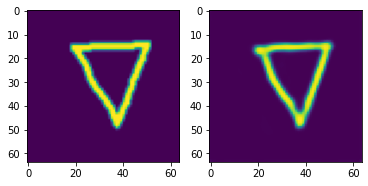

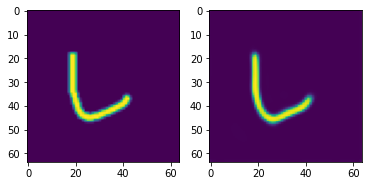

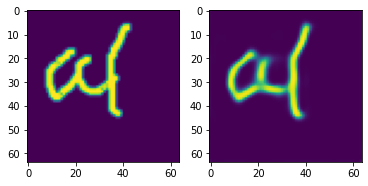

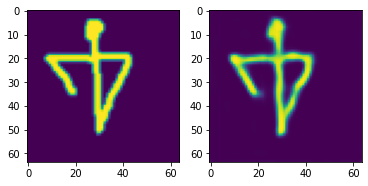

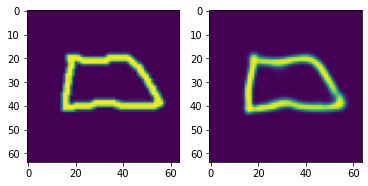

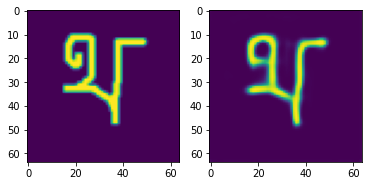

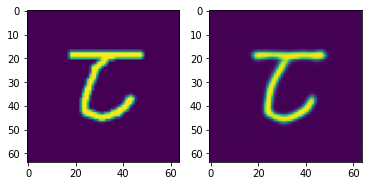

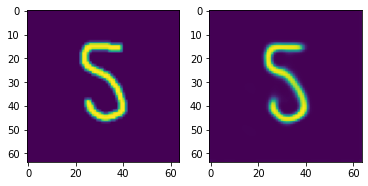

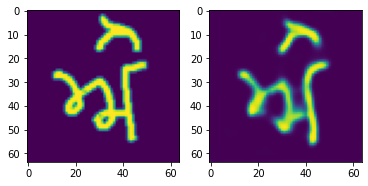

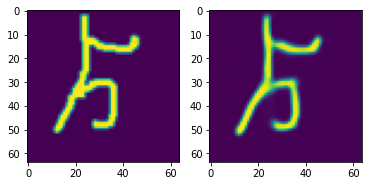

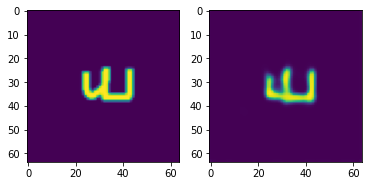

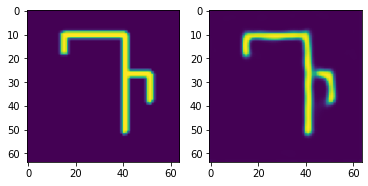

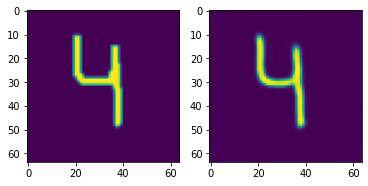

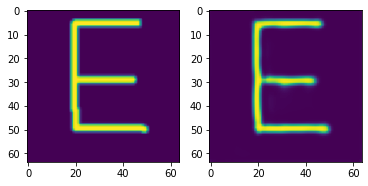

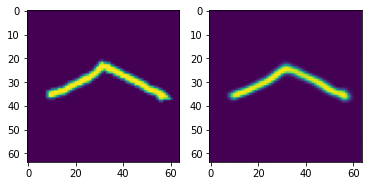

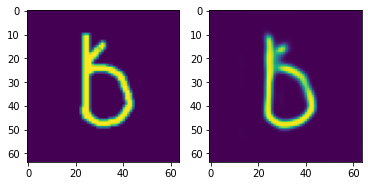

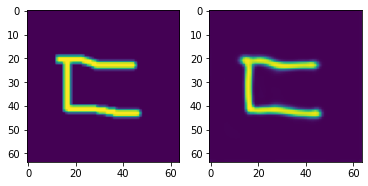

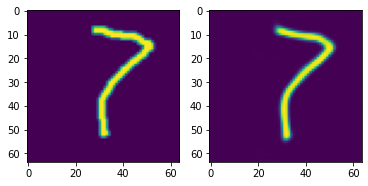

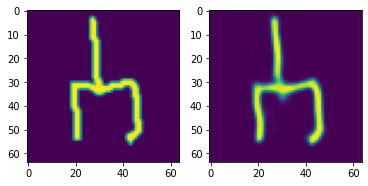

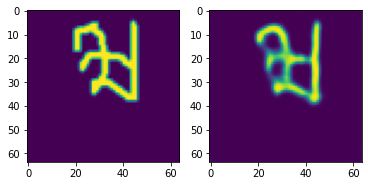

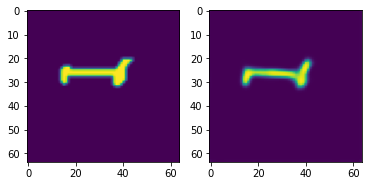

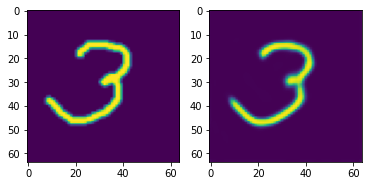

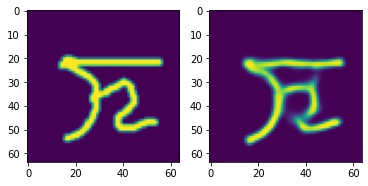

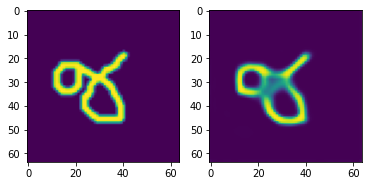

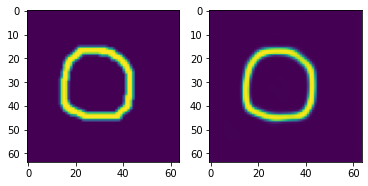

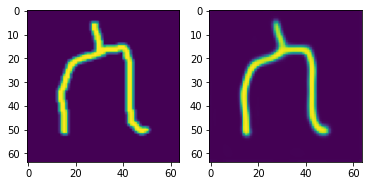

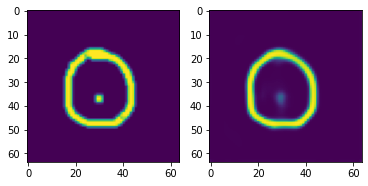

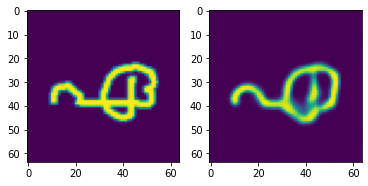

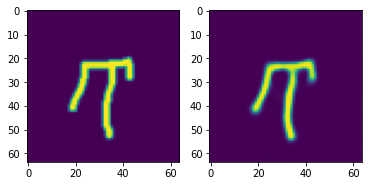

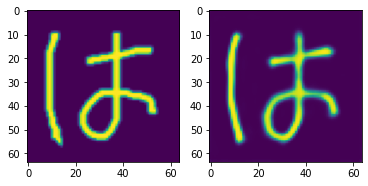

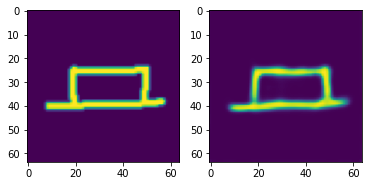

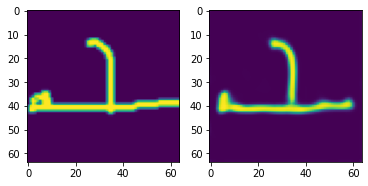

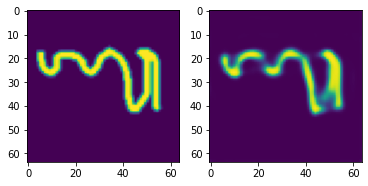

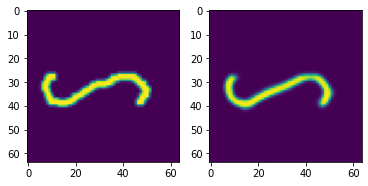

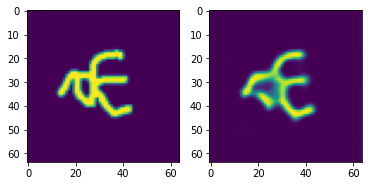

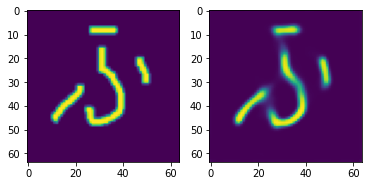

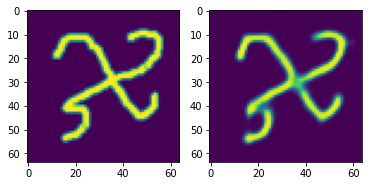

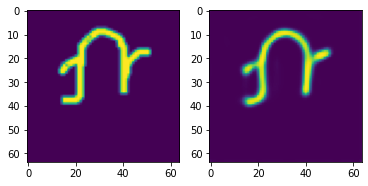

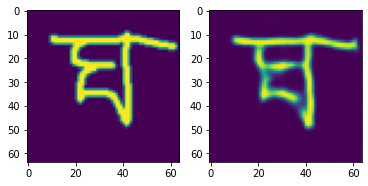

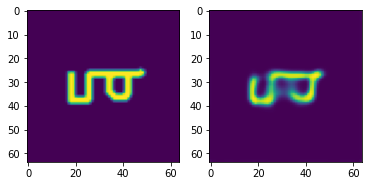

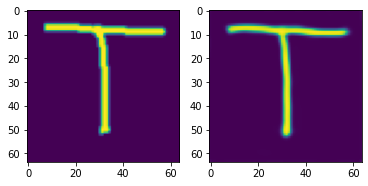

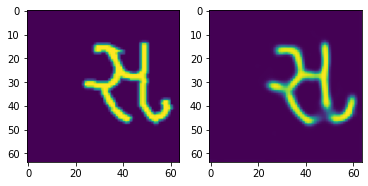

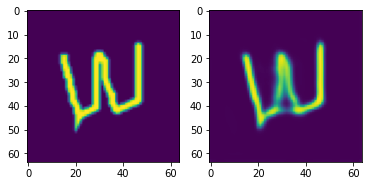

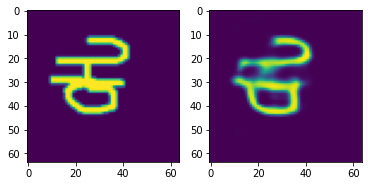

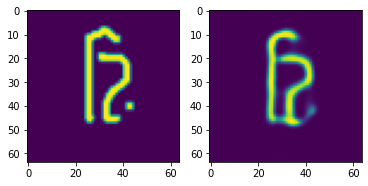

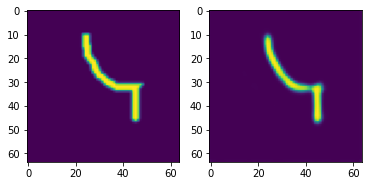

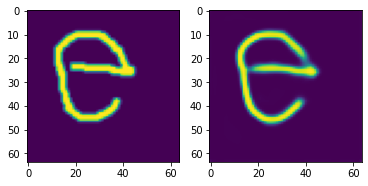

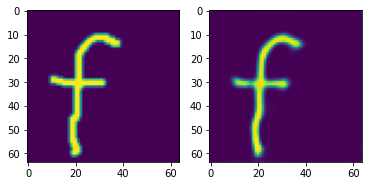

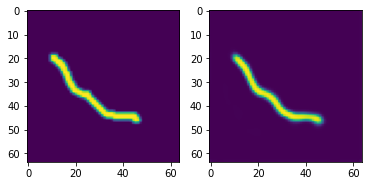

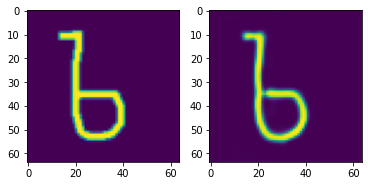

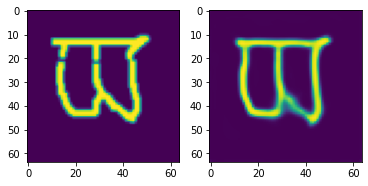

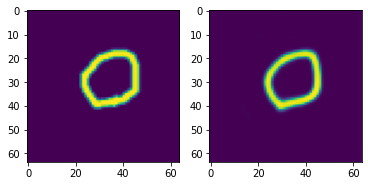

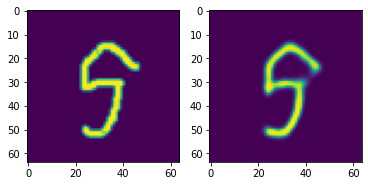

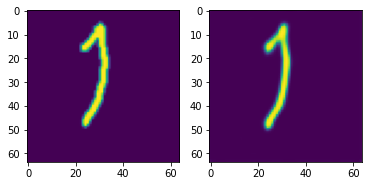

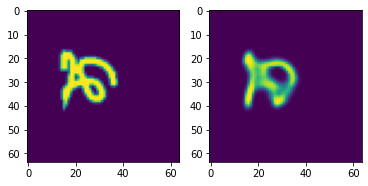

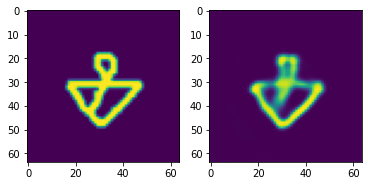

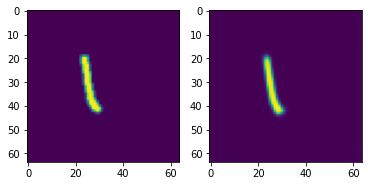

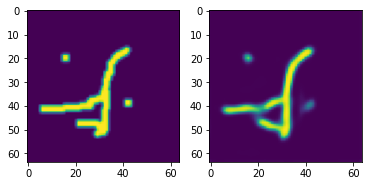

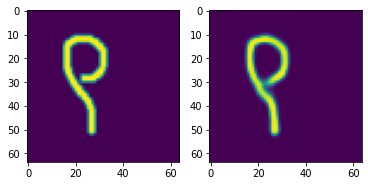

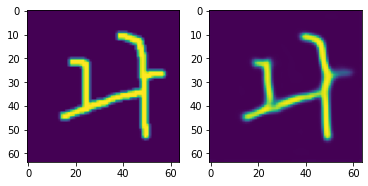

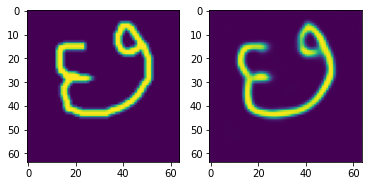

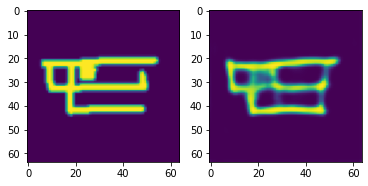

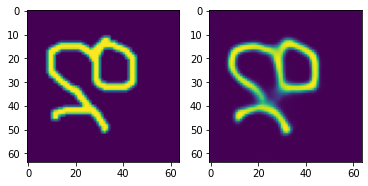

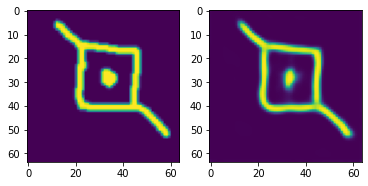

In [30]:
test_batch = next(iter(test_loader))
sae.eval()

for image in test_batch[0]:
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze())
    plt.subplot(1, 2, 2)
    plt.imshow(sae(image.unsqueeze(0).to(device)).squeeze().detach().to('cpu'))
    plt.show()

In [31]:
sae.eval()
test_losses = []

for image, _ in tqdm(test_loader, desc='test', leave = False):
    image = image.to(device)
    out = sae(image)
    loss = criterion(out, image)
    test_losses.append(loss.item())

print('Mean test loss is ', sum(test_losses) / len(test_losses))
wandb.log({'Mean test loss': sum(test_losses) / len(test_losses)})

Mean test loss is  0.03388696786016226


Опять, после 20 эпох качество неплохое. Поучим ещё

In [ ]:
losses, losses_with_l1 = train_sparse_autoencoder(
    model = sae,
    train_config = (optim, criterion, device),
    epochs = 40,
    data_loader = train_loader,
    wandb_config = ('DeepGenModels-AE-homework', config),
    start_logging = False
)

epoch: 100%|██████████| 40/40 [21:00<00:00, 31.51s/it]


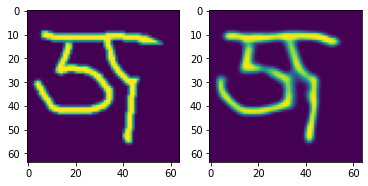

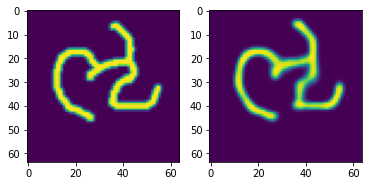

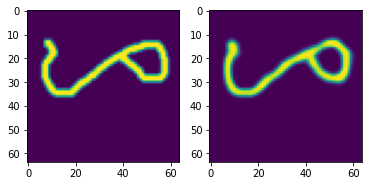

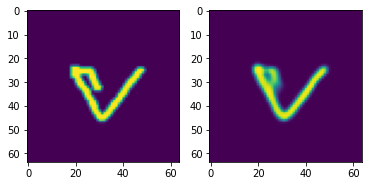

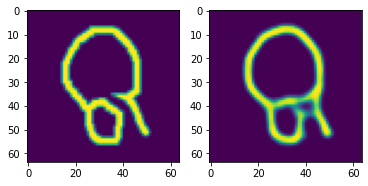

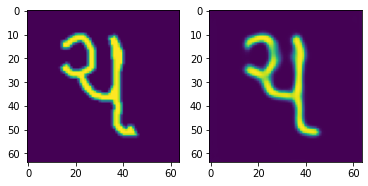

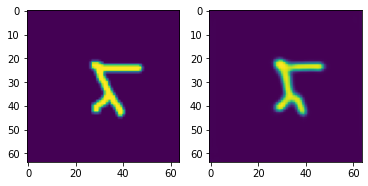

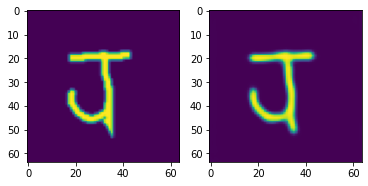

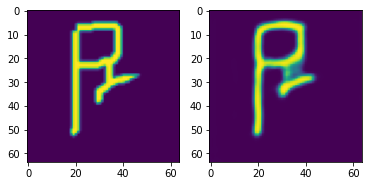

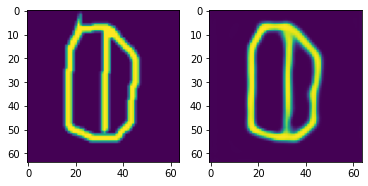

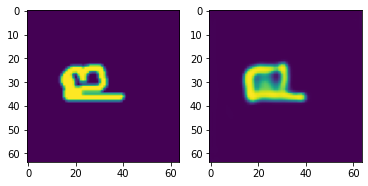

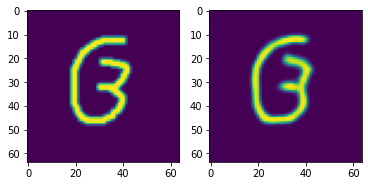

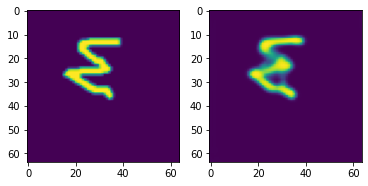

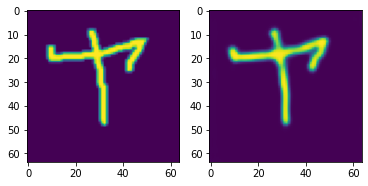

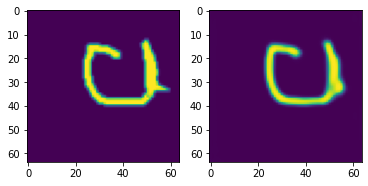

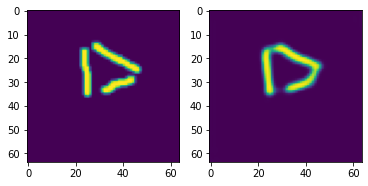

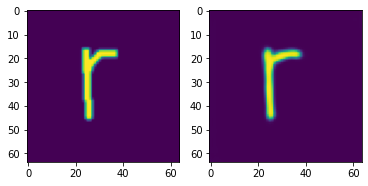

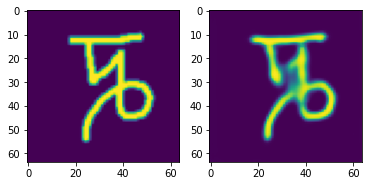

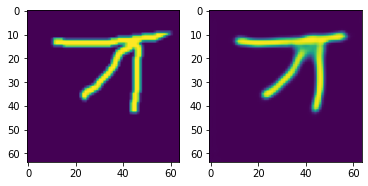

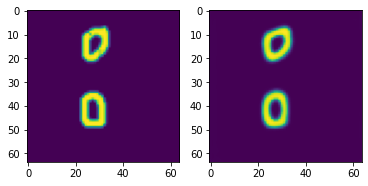

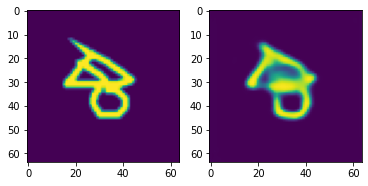

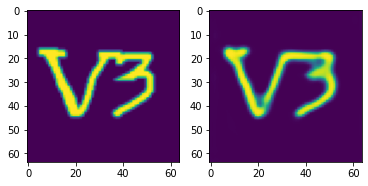

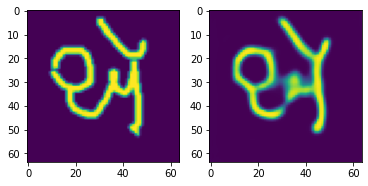

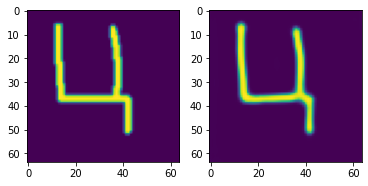

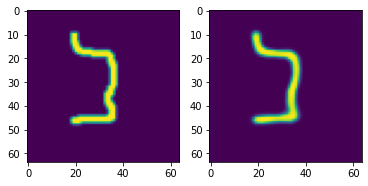

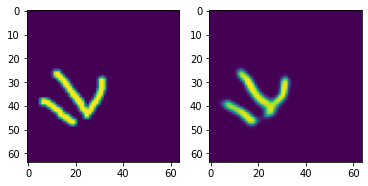

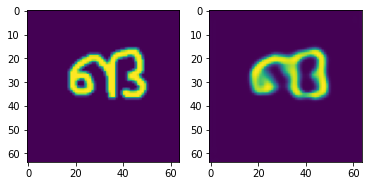

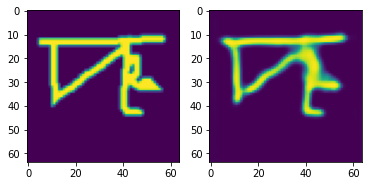

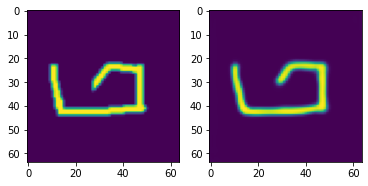

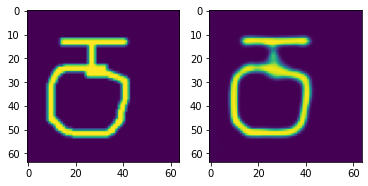

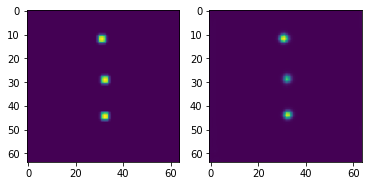

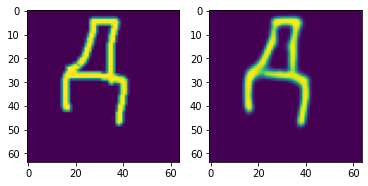

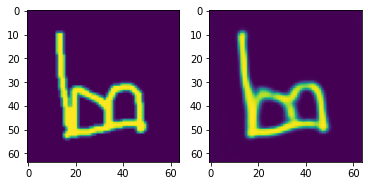

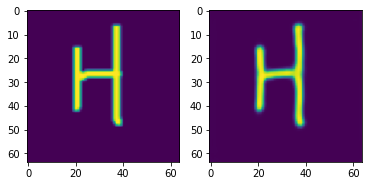

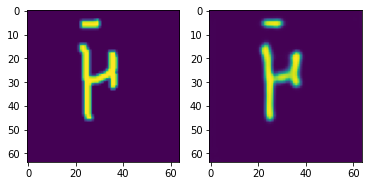

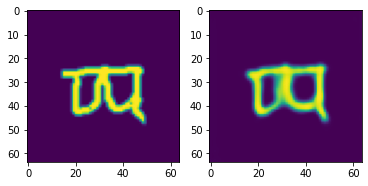

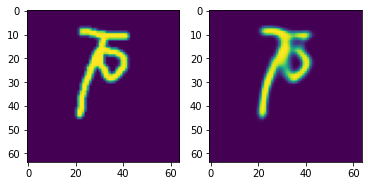

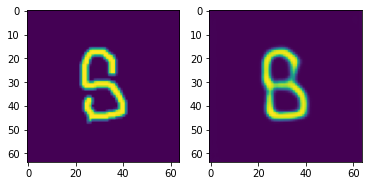

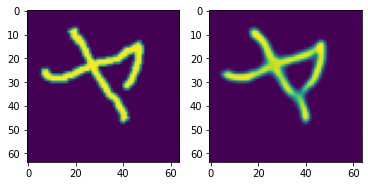

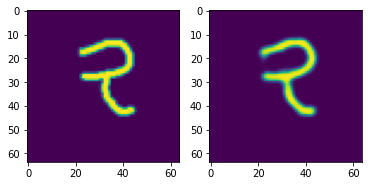

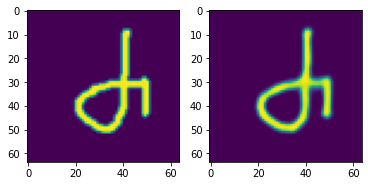

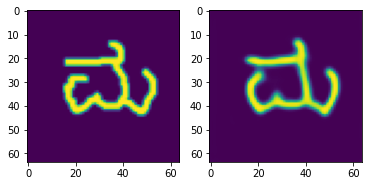

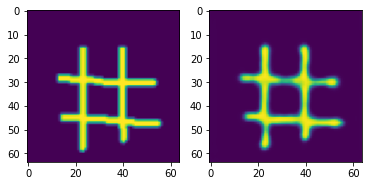

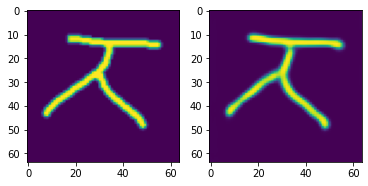

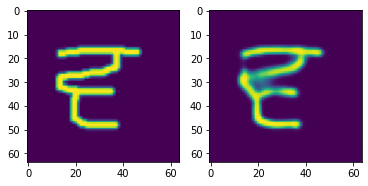

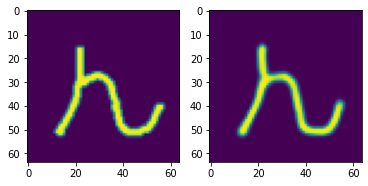

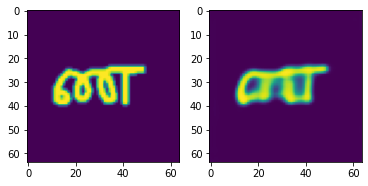

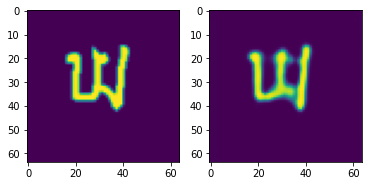

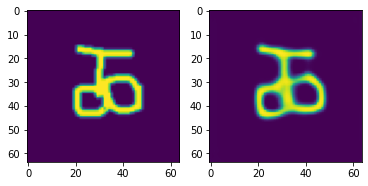

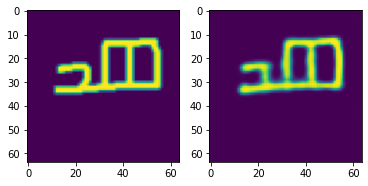

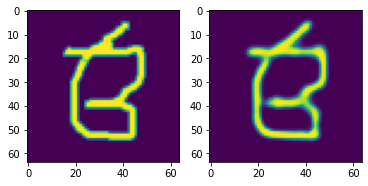

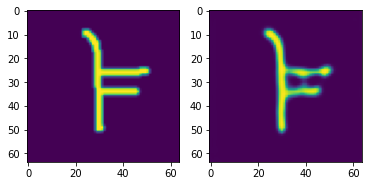

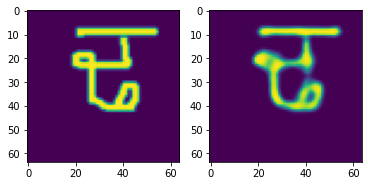

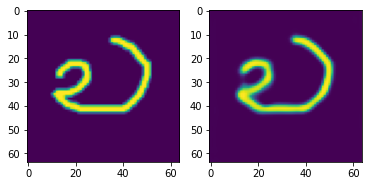

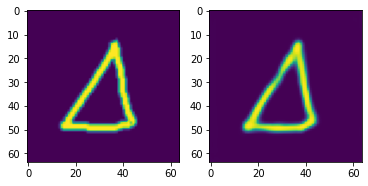

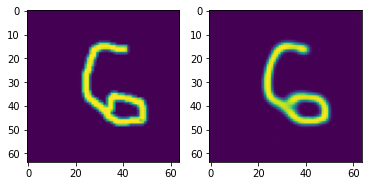

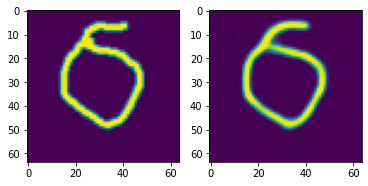

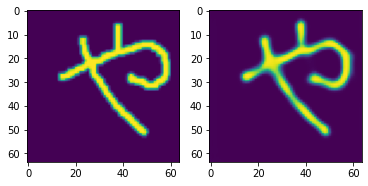

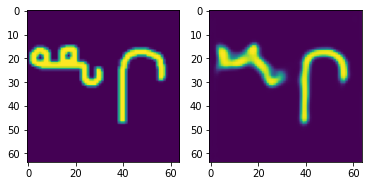

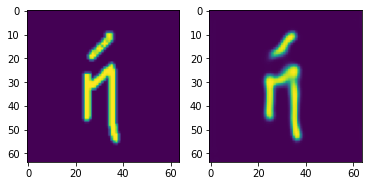

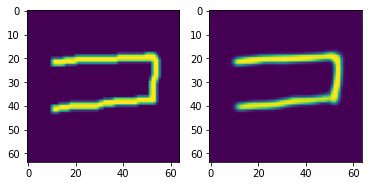

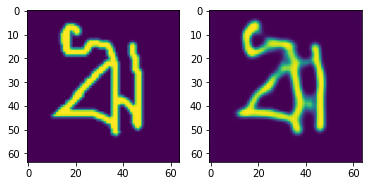

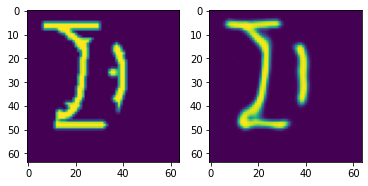

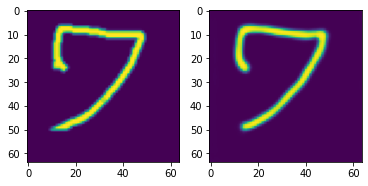

In [ ]:
test_batch = next(iter(test_loader))
sae.eval()

for image in test_batch[0]:
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze())
    plt.subplot(1, 2, 2)
    plt.imshow(sae(image.unsqueeze(0).to(device)).squeeze().detach().to('cpu'))
    plt.show()

#### Загрузка обученной модели

In [7]:
from sparse_autoencoder import SparseAutoEncoder

sae = SparseAutoEncoder().to(device)
path = 'drive/MyDrive/Colab Notebooks/'
sae.load_state_dict(torch.load(path + 'sae_0.02.pth'))

<All keys matched successfully>

#### Проверка sparse autoencoder-а на тесте

In [ ]:
criterion = nn.MSELoss()

In [ ]:
sae.eval()
test_losses = []

for image, _ in tqdm(test_loader, desc='test', leave = False):
    image = image.to(device)
    out = sae(image)
    loss = criterion(out, image)
    test_losses.append(loss.item())

print('Mean test loss is ', sum(test_losses) / len(test_losses))
#wandb.log({'Mean test loss': sum(test_losses) / len(test_losses)})

Mean test loss is  0.020911831259727478


In [ ]:
#torch.save(sae.state_dict(), 'drive/MyDrive/Colab Notebooks/deeper_sae.pth')

Мало посмотреть на результаты глазами, надо еще посчитать метрики качества.

Для этой задачи не очень хочется использовать FID с Inception обученными на ImageNet'е, поэтому предлагается обучить свою модель классификации на MNIST

Это можно сделать здесь (только красиво) или вынести в отдельную тетрадку/файлы

### Задача 2 (0.3 балла):

Научить внешний классификатор классифицировать MNIST, использовать его в подсчете FID между реальным Omniglot и выходами автоэнкодера

#### Подготовка данных

In [32]:
from torchvision.datasets import MNIST

mnist_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

mnist_dataset = MNIST('./MNIST', train=True, transform=data_transforms, download=True)
mnist_loader = DataLoader(mnist_dataset, batch_size=batch_size, drop_last=True, shuffle=True)


In [33]:
labels = [label for _, label in mnist_dataset]

indices_train, indices_test, _, _ = train_test_split(list(range(len(labels))), labels, test_size=0.1, stratify=labels)

mnist_train_dataset = Subset(mnist_dataset, indices=indices_train)
mnist_test_dataset = Subset(mnist_dataset, indices=indices_test)

batch_size = 64

mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=batch_size, drop_last=True)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=batch_size, drop_last=True)

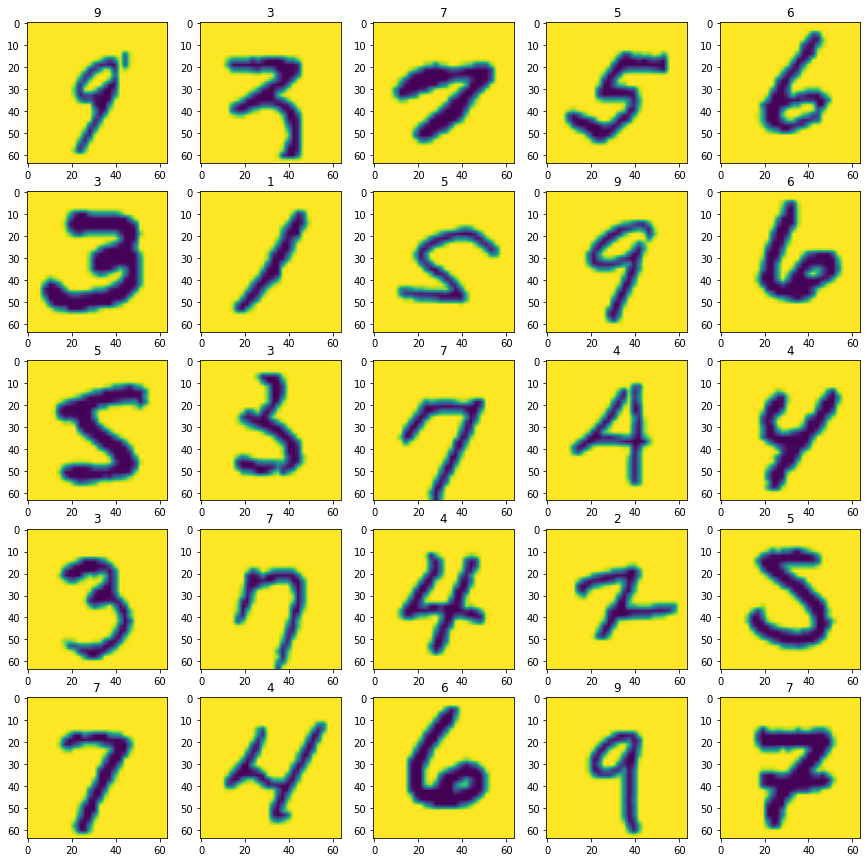

In [34]:
visuilizing_batch = next(iter(mnist_train_loader))

plt.figure(figsize = (15,15))

for index, (image, label) in enumerate(zip(*visuilizing_batch)):
    if index >= 25: 
        break
    plt.subplot(5, 5, index + 1)
    plt.imshow(process_image(image))
    plt.title(label.item())
plt.show()

Классификатор для MNIST

In [35]:
from classifier import Classifier

clf = Classifier(n_classes = 10).to(device)
optim = torch.optim.Adam(clf.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [36]:
def train_classifier(model, train_config, epochs, data_loader, wandb_config, start_logging):
    optim, criterion, device = train_config
    project_name, config = wandb_config

    if start_logging:
        wandb.init(project=project_name, config=config)
        wandb.watch(model)

    losses = []
    model.train()
    log_freq = 100

    for epoch in tqdm(range(epochs), desc = 'epochs'):
        for batch_index, (image, label) in enumerate(data_loader):
            optim.zero_grad()
            image = image.to(device)
            label = label.to(device)
            out = model(image)
            loss = criterion(out, label)
            loss.backward()
            optim.step()
            losses.append(loss.item())

            if batch_index % log_freq == log_freq - 1:
                running_loss = sum(losses[-log_freq:]) / log_freq
                wandb.log({'running_loss': running_loss})

    return losses

In [37]:
config = {
    "architechture": "Conv-FC-classifier",
    "loss": "Cross-entropy",
    "optimizer": "Adam",
    "learning_rate": 0.001,
    "dataset": "MNIST"
}

In [ ]:
losses = train_classifier(
    model = clf,
    train_config = (optim, criterion, device),
    epochs = 20,
    data_loader = mnist_train_loader,
    wandb_config = ('DeepGenModels-AE-homework-classifier', config),
    start_logging = True
)

#### Проверка классификатора на тесте

In [ ]:
from classifier import Classifier

clf = Classifier(n_classes = 10).to(device)
path = 'drive/MyDrive/Colab Notebooks/'
clf.load_state_dict(torch.load(path + 'fresh_classifier_0.99.pth'))
criterion = nn.CrossEntropyLoss()

In [39]:
test_losses = []
clf.eval()

correct = 0
total = 0

for image, label in tqdm(mnist_test_loader, desc = 'test loss and accuracy'):
    image = image.to(device)
    label = label.to(device)
    pred = clf(image)
    loss = criterion(pred, label)
    test_losses.append(loss.item())

    pred = pred.argmax(dim = 1)
    correct += torch.sum(pred == label)
    total += len(label)

print(f"Mean test loss {sum(test_losses) / len(test_losses)}, accuracy {correct/total}")


Mean test loss 0.07042960240714184, accuracy 0.9880712628364563


In [40]:
wandb.log({
     'Mean test loss': sum(test_losses) / len(test_losses),
     'accuracy': correct/total
})

In [ ]:
visuilizing_batch = next(iter(mnist_test_loader))
images, labels = visuilizing_batch

pred = clf(images.to(device)).argmax(dim = 1)

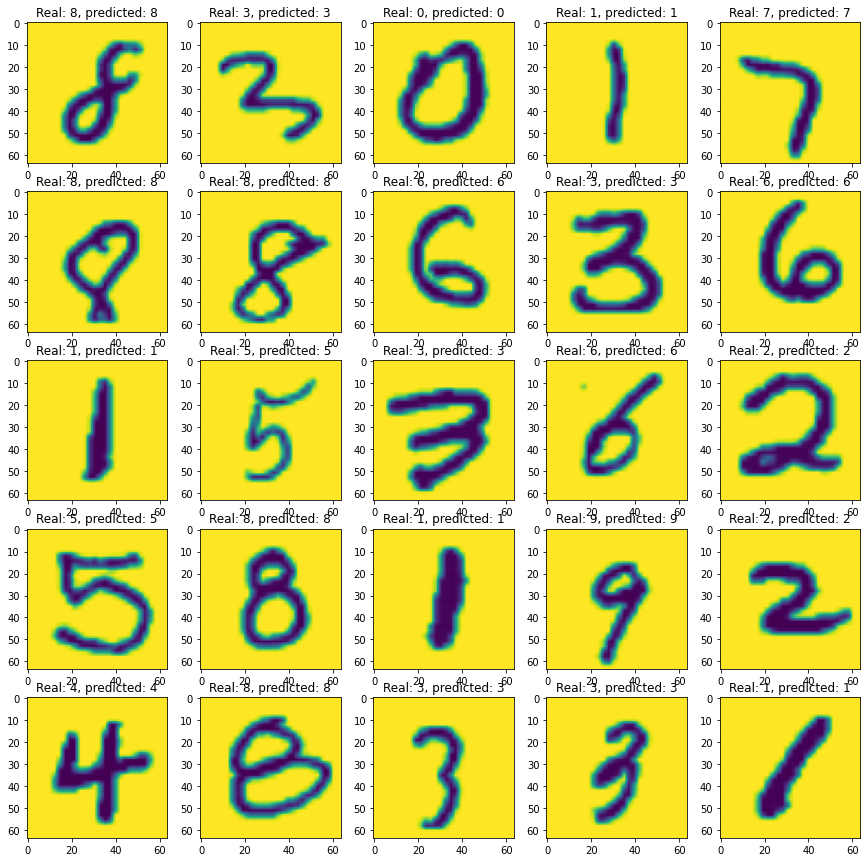

In [ ]:
plt.figure(figsize = (15,15))

for index, (image, label) in enumerate(zip(*visuilizing_batch)):
    if index >= 25: 
        break
    plt.subplot(5, 5, index + 1)
    plt.imshow(process_image(image))
    plt.title(f"Real: {label.item()}, predicted: {pred[index].item()}")
plt.show()

In [41]:
torch.save(clf.state_dict(), 'drive/MyDrive/Colab Notebooks/fresh_classifier_0.99.pth')

#### Freshet distance

In [ ]:
from calculate_fid import calculate_fid

print(f"FID for AE: {calculate_fid(test_loader, dae, clf)}")

FID for AE: 33.26758418342956


In [ ]:
class NoiseRecoModel(nn.Module):
    def __init__(self, intensivity=0.1):
        super().__init__()
        # self.placeholder_layer
        # ненужный слой, который позвоняет в calculate_fid смотреть на каком девайсе расположена сетка
        self.placeholder_layer = nn.Linear(1, 1)
        self.intensivity = intensivity
        
    def forward(self, x):
        return x + torch.rand_like(x) * self.intensivity

Проверим насколько наша метрика стабильна: чем больше шум, тем больше она должна становиться

In [ ]:
for noise_level in [0.001, 0.01, 0.05, 0.1, 0.5, 0.7, 1.]:
    noise_model = NoiseRecoModel(noise_level).to(device)
    print(f"FID for noise {noise_level}: {calculate_fid(test_loader, noise_model, clf)}")
    

FID for noise 0.001: 0.25717086243594167
FID for noise 0.01: 0.2608803912635267
FID for noise 0.05: 0.35098073018161813
FID for noise 0.1: 0.6006379737900716
FID for noise 0.5: 15.119994219911632
FID for noise 0.7: 46.52739001084251
FID for noise 1.0: 132.69160847259718


Понятно что сам по себе автоэнкодер - такая себе генеративная модель, хоть ее и можно использовать в таком качестве

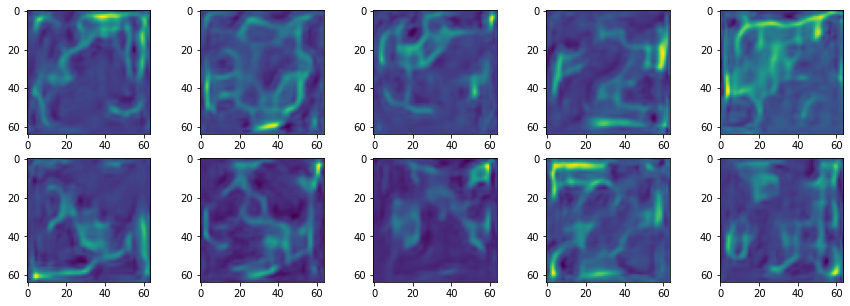

In [ ]:
sae.eval()

test_images = next(iter(test_loader))[0].to(device)
images_latent = sae.get_latent_features(test_images).to('cpu')

test_noise = torch.randn_like(images_latent) * 0.9
sampled_mnist = sae.decoder(test_noise.to(device)).to('cpu')
    
plt.figure(figsize=(15, 5))
for ind in range(10):
    plt.subplot(2, 5, ind+1)
    plt.imshow(sampled_mnist[ind].squeeze().detach())


Мы предлагаем использовать латентные фичи из AE для классификации.

Главная проблема классификации на Omniglot в том, что классов очень много и обычные классификаторы не могут справиться:

### Задача 3 (0.2 балла):

Попробовать честную классификацию на Omniglot, довести ее до приличного качества.

In [ ]:
#from classifier import Classifier

clf = Classifier(n_classes=1623).to(device)
optim = torch.optim.Adam(clf.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
config = {
    "architechture": "Conv-FC-classifier",
    "dropout": 0.2,
    "regularization": None,
    "loss": "Cross-entropy",
    "optimizer": "Adam",
    "learning_rate": 0.001,
    "dataset": "Omniglot",
}

In [ ]:
full_dataset = FullOmniglot('./Omniglot', transform=data_transforms, download=True)

labels = [label for _, label in full_dataset]
    
# делаем так, чтобы сплит был сбалансированным по классам
indices_train, indices_test, _, _ = train_test_split(list(range(len(labels))), labels, test_size=0.1, stratify=labels)

train_dataset = Subset(full_dataset, indices=indices_train)
test_dataset = Subset(full_dataset, indices=indices_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
losses = train_classifier(
    model = clf, 
    train_config = (optim, criterion, device), 
    epochs = 20,
    data_loader = train_loader, 
    wandb_config = ('DeepGenModels-AE-homework-classifier', config),
    start_logging = True
)

Посчитаем аккураси:

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
true_labels = []
clf_predict_labels = []
clf.eval() 

for image, label in tqdm(test_loader, desc='test clf loop', leave=True):
    image = image.to(device)
    pred = clf(image)
    pred = pred.argmax(dim = 1).to('cpu')

    true_labels.append(label)
    clf_predict_labels.append(pred)

true_labels = torch.cat(true_labels, dim=0).numpy()
clf_predict_labels = torch.cat(clf_predict_labels, dim=0).numpy()

In [ ]:
print(f"random accuracy: {1/1623}")
print(f"CNN accuracy: {accuracy_score(true_labels, clf_predict_labels)}")

random accuracy: 0.0006161429451632779
CNN accuracy: 0.64625


Возможное решение проблемы с классификацией - обработка данный автоэнкодером и использование преобразованных латентных фичей вместо картинок.

Латентные фичи можно представить в виде табличных 1D данных, на которых можно учить даже разные бустинги.


### Задача 4 (0.2 балла):

Получить латентные представления от картинок в Omniglot, выучить любую (хорошую) модель классификации на них до адекватного качества.

note: не забывайте учить на трейне, а считать аккураси на тесте

#### Подготовка данных:

In [8]:
test_latent_omniglot = []
test_labels = []

for image, label in tqdm(test_loader):
    image = image.to(device)
    # Можно подставить как dae, так sae, 
    # только нужно поправить размерность при решейпинге
    repr = sae.get_latent_features(image).detach().to('cpu').view(-1, 1024)
    test_latent_omniglot.append(repr)
    test_labels.append(label)

test_latent_omniglot = torch.cat(test_latent_omniglot, dim = 0).numpy()
test_labels = torch.cat(test_labels, dim = 0).numpy()

In [9]:
train_latent_omniglot = []
train_labels = []

for image, label in tqdm(train_loader, desc='Getting latent'):
    image = image.to(device)
    repr = sae.get_latent_features(image).detach().to('cpu').view(-1, 1024)
    train_latent_omniglot.append(repr)
    train_labels.append(label)

train_latent_omniglot = torch.cat(train_latent_omniglot, dim = 0).numpy()
train_labels = torch.cat(train_labels, dim = 0).numpy()

In [10]:
train_latent_omniglot.shape, train_labels.shape

((29184, 1024), (29184,))

#### LGBM

Поставим LGBM так, чтобы можно было использовать GPU

In [ ]:
!pip uninstall lightgbm

In [ ]:
!pip install lightgbm --install-option=--gpu

In [ ]:
import lightgbm as lgb

In [ ]:
lgb_clf = lgb.LGBMClassifier(
    boosting_type='gbdt',
    device='gpu',
    n_estimators = 50,
    max_depth = 10,
    feature_fraction = 0.6,
    bagging_fraction = 0.6,
    bagging_freq = 5
)

In [ ]:
lgb_clf.fit(
    train_latent_omniglot,
    train_labels,
    eval_set = [(test_latent_omniglot, test_labels)],
    eval_metric = ['multi_logloss', 'multi_error']
)

[1]	valid_0's multi_logloss: 23.6456	valid_0's multi_error: 0.95625
[2]	valid_0's multi_logloss: 34.2414	valid_0's multi_error: 0.993125
[3]	valid_0's multi_logloss: 34.4416	valid_0's multi_error: 0.997188
[4]	valid_0's multi_logloss: 34.4999	valid_0's multi_error: 0.999375
[5]	valid_0's multi_logloss: 34.4692	valid_0's multi_error: 0.998437
[6]	valid_0's multi_logloss: 34.4674	valid_0's multi_error: 0.998125
[7]	valid_0's multi_logloss: 34.4689	valid_0's multi_error: 0.998125
[8]	valid_0's multi_logloss: 34.4127	valid_0's multi_error: 0.996875
[9]	valid_0's multi_logloss: 34.4632	valid_0's multi_error: 0.997812
[10]	valid_0's multi_logloss: 34.4848	valid_0's multi_error: 0.998437
[11]	valid_0's multi_logloss: 34.4135	valid_0's multi_error: 0.996875
[12]	valid_0's multi_logloss: 34.4333	valid_0's multi_error: 0.997188
[13]	valid_0's multi_logloss: 34.4005	valid_0's multi_error: 0.99625
[14]	valid_0's multi_logloss: 34.3761	valid_0's multi_error: 0.995625
[15]	valid_0's multi_logloss: 3

LGBMClassifier(bagging_fraction=0.6, bagging_freq=5, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, device='gpu',
               feature_fraction=0.6, importance_type='split', learning_rate=0.1,
               max_depth=10, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=50, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
from sklearn.metrics import accuracy_score

pred = lgb_clf.predict(test_latent_omniglot)

print(f"random accuracy: {1/1623}")
print(f"lgbm + AE accuracy: {accuracy_score(test_labels, pred)}")

random accuracy: 0.0006161429451632779
lgbm + AE accuracy: 0.0046875


In [ ]:
pred = lgb_clf.predict(train_latent_omniglot)

print(f"lgbm + AE accuracy: {accuracy_score(train_labels, pred)}")

lgbm + AE accuracy: 0.005619517543859649


Печаль тоска

#### Random forest from sklearn

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(n_estimators=100, verbose = 3, min_samples_split=20)
clf.fit(train_latent_omniglot, train_labels)

In [ ]:
y = clf.predict(test_latent_omniglot)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


In [ ]:
y, test_labels

(array([1447,  590, 1489, ...,   28,  803, 1287]),
 array([1032,  370,  583, ...,  657,  957, 1287]))

In [ ]:
sum(y == test_labels) / y.size

0.13625

Не сильно лучше

#### ~~Desperation~~ Perceptron

In [15]:
train_dataset_omniglot = torch.utils.data.TensorDataset(
    torch.Tensor(train_latent_omniglot), 
    torch.Tensor(train_labels).long()
)
train_loader_omniglot = DataLoader(train_dataset_omniglot, batch_size=64, drop_last=True)

test_dataset_omniglot = torch.utils.data.TensorDataset(
    torch.Tensor(test_latent_omniglot), 
    torch.Tensor(test_labels).long()
)
test_loader_omniglot = DataLoader(test_dataset_omniglot, batch_size=64, drop_last=True)

In [12]:
class FCBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.fc = nn.Linear(in_channels, out_channels)
        self.act = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        return self.dropout(self.act(self.fc(x)))

class Perceptron(nn.Module):
    def __init__(self, features_amount, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            FCBlock(features_amount, 2048),
            FCBlock(2048, out_channels).fc
        )

    def forward(self, x):
        return self.net(x)

In [21]:
clf = Perceptron(1024, 1623).to(device)

# Можно загрузить обученный 
clf.load_state_dict(torch.load(path + 'latent_clf_0.45.pth'))

<All keys matched successfully>

In [17]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(clf.parameters(), weight_decay=5e-4)

In [ ]:
config = {
    "architechture": "Perceptron",
    "dropout": 0.3,
    "activation": "LeakyReLU",
    "regularization": None,
    "loss": "Cross-entropy",
    "optimizer": "Adam",
    "learning_rate": 0.001,
    "dataset": "Omniglot"
}

wandb.init(project='DeepGenModels-AE-homework-classifier', config = config)
wandb.watch(clf)

In [ ]:
losses = []

log_freq = 100
clf.train()

for epoch in tqdm(range(80), desc = 'epoch'):
    for batch_index, (repr, label) in enumerate(train_loader_omniglot):
        label = label.to(device)
        repr = repr.to(device)
        
        optim.zero_grad()
        out = clf(repr)
        loss = criterion(out, label)
        loss.backward()
        optim.step()

        losses.append(loss.item())
        if batch_index % log_freq == log_freq - 1:
            wandb.log({
                'running_loss': sum(losses[-log_freq:]) / log_freq
            })



In [22]:
test_losses = []
clf.eval()

correct = 0
total = 0

for image, label in tqdm(test_loader_omniglot, desc = 'test loss and accuracy'):
    image = image.to(device)
    label = label.to(device)
    pred = clf(image)
    loss = criterion(pred, label)
    test_losses.append(loss.item())

    pred = pred.argmax(dim = 1)
    correct += torch.sum(pred == label)
    total += len(label)

print(f"Mean test loss {sum(test_losses) / len(test_losses)}, accuracy {correct/total}")


Mean test loss 0.49798760265111924, accuracy 0.93812495470047


In [23]:
train_losses = []
clf.eval()

trn_correct = 0
trn_total = 0

for image, label in tqdm(train_loader_omniglot, desc = 'train loss and accuracy'):
    image = image.to(device)
    label = label.to(device)
    pred = clf(image)
    loss = criterion(pred, label)
    train_losses.append(loss.item())

    pred = pred.argmax(dim = 1)
    trn_correct += torch.sum(pred == label)
    trn_total += len(label)

print(f"Mean train loss {sum(train_losses) / len(train_losses)}, train accuracy {trn_correct / trn_total}")


Mean train loss 0.5264023327056253, train accuracy 0.9316748976707458


In [ ]:
wandb.log({
    'Mean test loss': sum(test_losses) / len(test_losses),
    'accuracy': correct/total,
    'Mean train loss': sum(train_losses) / len(train_losses),
    'train accuracy': trn_correct / trn_total
})

In [ ]:
#torch.save(clf.state_dict(), path + 'latent_clf_0.45.pth')